In [1]:
if get_ipython().__class__.__name__ == 'ZMQInteractiveShell':
    %cd ..

/notebooks


In [2]:
import os
import sys
import numpy as np
import torch
from swa import SWA
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader import WseDataset
from utils import train, predict, printc
from models.vgg import Vgg
try:
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import summary_table
except ModuleNotFoundError:
    !pip install statsmodels -q
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import summary_table
import pickle
import math
import matplotlib.pyplot as plt
import shutil
try:
    import neptune.new as neptune
except ModuleNotFoundError:
    !pip install neptune-client -q
    import neptune.new as neptune

In [3]:
PARAMS = {
    "img_size": 256,
    "model": "vgg",#"vgg"
    "lr_base": 0.000001,#0.00001,
    "lr_max": 0.00001,#0.00001,
    "swa_start": 6,
    "swa_freq": 2,
    "swa_lr": 0.000002,
    "batch_size": 32,
    'epochs': 50,
    'task': "all",#"all", "train", "predict"
    'neptune': False,
    'es_patience': 10,#10,#15, # early stopping (es), negative - early stopping disabled
    'es_min_delta': 0.001, # early stopping (es)
    'drop_rate': 0.5, # dropout rate
    'train_subsets': ["GRO20", "RYB20", "RYB21"],
    'valid_subsets': ["GRO21"],
    'test_subsets': None,
    'dropout_averaging': True,
    'overtrain': False,
    'min_range': 0.,#4.,
    'max_range': 4.5,#float('inf'),
    'pretrained_weights': None,#"output/DEN1-1067/state_dict.pth",#None,#None,# None,"state_dict.pth",
    'optimizer': "adam"#"adam"/"swa"/"sgd"
}

dataset_dir = os.path.normpath("dataset")
csv_path = os.path.join(dataset_dir,"dataset.csv")


In [4]:
if get_ipython().__class__.__name__ != 'ZMQInteractiveShell':
    if len(sys.argv)>1:
        PARAMS['train_subsets']=None if sys.argv[1]=="None" else sys.argv[1].split(",")
        PARAMS['valid_subsets']=None if sys.argv[2]=="None" else sys.argv[2].split(",")
        PARAMS['test_subsets']=None if sys.argv[3]=="None" else sys.argv[3].split(",")
print(PARAMS)

{'img_size': 256, 'model': 'vgg', 'lr_base': 1e-06, 'lr_max': 1e-05, 'swa_start': 6, 'swa_freq': 2, 'swa_lr': 2e-06, 'batch_size': 32, 'epochs': 50, 'task': 'all', 'neptune': True, 'es_patience': 10, 'es_min_delta': 0.001, 'drop_rate': 0.5, 'train_subsets': ['GRO20', 'RYB20', 'RYB21'], 'valid_subsets': ['GRO21'], 'test_subsets': None, 'dropout_averaging': True, 'overtrain': False, 'min_range': 0.0, 'max_range': 4.5, 'pretrained_weights': None, 'optimizer': 'adam'}


In [5]:
os.makedirs("output", exist_ok=True)
if PARAMS["neptune"]:
    import configparser
    config = configparser.ConfigParser()
    assert os.path.exists("ml/config.cfg")
    config.read("ml/config.cfg")

    neptune_run = neptune.init(project=config["neptune"]["project"],
              api_token=config["neptune"]["token"],
              source_files=['ml/main.py', f"ml/models/{PARAMS['model']}.py", 'ml/utils.py', 'ml/dataloader.py']
              )
    neptune_run["parameters"] = PARAMS
    output_name = neptune_run.get_structure()['sys']['id'].fetch()
    output_dir = f"output/{output_name}"
    os.mkdir(output_dir)
else:
    neptune_run=None
    output_dir = f"output/{PARAMS['valid_subsets'][0]}"
    if os.path.exists(output_dir) and os.path.isdir(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)
# device detection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")
if str(device) == "cuda":
    for i in range(torch.cuda.device_count()):
      print(f"\tcuda:{i}: {torch.cuda.get_device_name(i)}")

# model loading
if PARAMS["model"]=="vgg":
    model = Vgg(input_size=PARAMS["img_size"], drop_rate=PARAMS["drop_rate"]).to(device)
    printc(model, "Model:")
if PARAMS["pretrained_weights"]:
    model.load_state_dict(torch.load(PARAMS["pretrained_weights"]))

https://ui.neptune.ai/radek/denoise1/e/DEN1-1082
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
device: cuda
	cuda:0: Quadro P5000


In [6]:
if PARAMS["train_subsets"]:
    train_dataset = WseDataset(csv_path=csv_path, img_size=PARAMS['img_size'], augment=True, subsets=PARAMS["train_subsets"], min_range = PARAMS["min_range"], max_range = PARAMS["max_range"])
    train_dataloader = DataLoader(train_dataset, batch_size=PARAMS['batch_size'], shuffle=True)
else:
    train_dataloader = None
if PARAMS["valid_subsets"]:    
    valid_dataset = WseDataset(csv_path=csv_path, img_size=PARAMS['img_size'], augment=False, subsets=PARAMS["valid_subsets"], min_range = PARAMS["min_range"], max_range = PARAMS["max_range"])
    valid_dataloader = DataLoader(valid_dataset, batch_size=PARAMS['batch_size'], shuffle=False)
else:
    valid_dataloader = None
if PARAMS["test_subsets"]:    
    test_dataset = WseDataset(csv_path=csv_path, img_size=PARAMS['img_size'], augment=False, subsets=PARAMS["test_subsets"], min_range = PARAMS["min_range"], max_range = PARAMS["max_range"])
    test_dataloader = DataLoader(test_dataset, batch_size=PARAMS['batch_size'], shuffle=False)
else:
    test_dataloader = None
    
if PARAMS["optimizer"] == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS["lr_base"])
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=PARAMS["lr_base"], max_lr=PARAMS["lr_max"],step_size_up=2,mode="triangular",cycle_momentum=False)
elif PARAMS["optimizer"] == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr=PARAMS["learning_rate"])
elif PARAMS["optimizer"] == "swa":
    #base_optimizer = torch.optim.SGD(model.parameters(), lr=PARAMS["learning_rate"])
    base_optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS["lr_base"])
    optimizer = SWA(base_optimizer, swa_start=PARAMS["swa_start"], swa_freq=PARAMS["swa_freq"], swa_lr=PARAMS["lr_max"])

model = train(model=model,
            train_dataloader=train_dataloader,
            valid_dataloader=valid_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            num_epochs=PARAMS['epochs'],
            es_patience=PARAMS['es_patience'],
            es_min_delta=PARAMS['es_min_delta'],
            dropout_averaging=PARAMS["dropout_averaging"],
            output_dir=output_dir,
            neptune_run=neptune_run
           )

Epoch 0/50. LR: 1e-06


 84%|████████▍ | 59/70 [00:34<00:06,  1.71it/s]

Keyboard Interrupt
Best rmse_valid:  inf


Dropout averaging...
train RMSE: 0.6781188132056087
Dropout averaging...
valid RMSE: 0.9703545552675855
Test regression RMSE: 0.9233506461937939
Test mean error: 0.13976271869388165
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 21 operations to synchronize with Neptune. Do not kill this process.
All 21 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://ui.neptune.ai/radek/denoise1/e/DEN1-1082


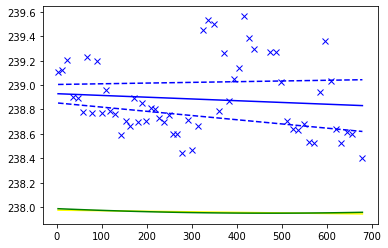

In [7]:
if PARAMS["train_subsets"]:
    train_dataset = WseDataset(csv_path=csv_path, img_size=PARAMS['img_size'], augment=False, subsets=PARAMS["train_subsets"], min_range = PARAMS["min_range"], max_range = PARAMS["max_range"])
    train_dataloader = DataLoader(train_dataset, batch_size=PARAMS['batch_size'], shuffle=False)
else:
    train_dataloader = None
if PARAMS["valid_subsets"]:
    valid_dataset = WseDataset(csv_path=csv_path, img_size=PARAMS['img_size'], augment=False, subsets=PARAMS["valid_subsets"], min_range = PARAMS["min_range"], max_range = PARAMS["max_range"])
    valid_dataloader = DataLoader(valid_dataset, batch_size=PARAMS['batch_size'], shuffle=False)
else:
    valid_dataloader = None
if train_dataloader:
    predict(model, dataloader=train_dataloader, averaging=PARAMS['dropout_averaging'], device=device, output_name="train", dropout_averaging=PARAMS["dropout_averaging"], output_dir=output_dir, neptune_run=neptune_run)
if valid_dataloader:
    predict(model, dataloader=valid_dataloader, averaging=PARAMS['dropout_averaging'], device=device, output_name="valid", dropout_averaging=PARAMS["dropout_averaging"], output_dir=output_dir, neptune_run=neptune_run)
    result_dict_path = f"{output_dir}/predictions/valid.pickle"
    if PARAMS["neptune"]:
        neptune_run[f"predict/test/result_dict"].upload(result_dict_path)
    with open(result_dict_path, 'rb') as f:
        result_dict = pickle.load(f)
        gt_y = result_dict["info"]["wse"].to_numpy()
        mean_y = result_dict["predict"].mean(axis=0).to_numpy()
        std_y = result_dict["predict"].std(axis=0).to_numpy()
        fit_x = result_dict["info"]["chain"].to_numpy()
        gt_reg = sm.OLS(gt_y, sm.add_constant(fit_x)).fit()
        pr_reg = sm.OLS(mean_y, sm.add_constant(fit_x)).fit()
        pr_st, pr_data, pr_ss2 = summary_table(pr_reg, alpha=0.05)
        gt_st, gt_data, gt_ss2 = summary_table(gt_reg, alpha=0.05)
        pred_y = pr_data[:,2]
        gt_pred_y = gt_data[:,2]
        #predict_ci_low, predict_ci_upp = pr_data[:,6:8].T
        b, a = pr_reg.params
        b_std, a_std = pr_reg.bse
        predict_low = (a-a_std)*fit_x + (b-b_std)
        predict_upp = (a+a_std)*fit_x + (b+b_std)
        errors = predict_upp - pred_y
        regression_rmse = np.sqrt(((pred_y-result_dict["info"]["wse"])**2).mean())
        mean_error = (pred_y-predict_low).mean()
        print(f"Test regression RMSE: {regression_rmse}")
        if PARAMS["neptune"]:
            neptune_run[f"predict/test/regression_RMSE"] = regression_rmse
        print(f"Test mean error: {mean_error}")
        if PARAMS["neptune"]:
            neptune_run[f"predict/test/regression_error"] = mean_error
        slopes = {"slope_mm_gt": (gt_pred_y[-1]-gt_pred_y[0])/(fit_x[-1]-fit_x[0]),
                  "slope_deg_gt": math.degrees(math.atan(gt_reg.params[1])),
                  "slope_mm_pr": (pred_y[-1]-pred_y[0])/(fit_x[-1]-fit_x[0]),
                  "slope_deg_pr": math.degrees(math.atan(pr_reg.params[1]))}
        if PARAMS["neptune"]:
            neptune_run[f"predict/test/slopes"] = slopes
            neptune_run[f"predict/test/slope_diff_deg"] = slopes["slope_deg_gt"]-slopes["slope_deg_pr"]
        plt.plot(result_dict["info"]["chain"],gt_pred_y, "-", label="Ground truth linear", color="yellow")
        plt.plot(result_dict["info"]["chain"],result_dict["info"]["wse"], "-", label="Ground truth", color="green")
        plt.plot(result_dict["info"]["chain"],result_dict["predict"].mean(axis=0), "x", label="CNN output", color="blue")
        plt.plot(result_dict["info"]["chain"],pred_y, "-", label="CNN output regression", color="blue")
        plt.plot(result_dict["info"]["chain"],predict_low, "--", label="Error Up", color="blue")
        plt.plot(result_dict["info"]["chain"],predict_upp, "--", label="Error Down", color="blue")
        if PARAMS["neptune"]:
            neptune_run[f"predict/test/figure"].upload(neptune.types.File.as_image(plt.gcf()))
if PARAMS["neptune"]:
    neptune_run.stop()
